# SCP Toolbox Workshop

___A tutorial on generating dynamically feasible trajectories reliably and efficiently___

Monday, February 7, 2022

Rocky Mountain AAS GN&C Conference, Breckenridge, CO

In [842]:
import Pkg
Pkg.activate("..")

# these lines are required only for local installations
Pkg.develop(path="../../scp_traj_opt/")
Pkg.precompile()

using SCPToolbox
using PyPlot, Colors, LinearAlgebra

# Import the different possible low-level convex solvers
using COSMO
using Ipopt
using SCS
using ECOS
using OSQP

  Activating project at `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial`
   Resolving package versions...
  No Changes to `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial/Project.toml`
  No Changes to `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial/Manifest.toml`


# Part 4: Rocket-Landing Guidance

In [843]:
pbm = TrajectoryProblem();

## Rocket dynamics

In general, the dynamics of any nonlinear system are given by:

$$
\dot x(t) = f( t, x(t), u(t), p )
$$

* $t\in \mathbb R$: time;
* $x(t)\in \mathbb R^n$: state vector;
* $u(t)\in \mathbb R^m$: input vector (the things that we can decide on);
* $p(t)\in \mathbb R^d$: "parameter" vector (problem specific);

In [844]:
n, m, d = 7, 2, 1
problem_set_dims!(pbm, n, m, d)

## Rocket parameters

In [845]:
# Environment parameters
g = 3.0 #1.625 # [m/s^2] Gravitational acceleration of the planet
g_E = 9.807; # [m/s^2] Earth gravity

In [846]:
# Mechanical parameters
m_wet = 25e3
L = 5.0 # Thrust lever arm
J = 100e3; # [kg*m^2] Moment of inertia

In [847]:
# Propulsion parameters
Isp = 370 # [s] Specific impulse
T_min = 5e3 # [N] Minimum thrust
T_max = 66e3 # [N] Maximum thrust
α = 1 / (Isp * g_E)
δ_max = deg2rad(10.0);

In [848]:
# Trajectory parameters
γ_gs = deg2rad(10.0); # [rad] Glideslope angle (measured from the horizon)

In [849]:
f(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    if t <0.01
        # println("f: final time tf = ", tf)
    end
    return [vx; vy; -(T/m)*sin(θ+δ); (T/m)*cos(θ+δ)-g; ω; -(L*T/J)*sin(δ); -α*T]*tf
end;

SCP algorithms work by iteratively linearizing nonconvex elements of the problem. This means that we have to provide the algorithm with the Jacobians of $f$.

\begin{align}
A(t, x, u, p) &= \nabla_x f(t, x, u, p), \\
B(t, x, u, p) &= \nabla_u f(t, x, u, p), \\
F(t, x, u, p) &= \nabla_p f(t, x, u, p).
\end{align}

In [850]:
A(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    if t <0.01
        #println("A: final time tf = ", tf)
    end
    return [0 0 1 0       0       0       0
            0 0 0 1       0       0       0
            0 0 0 0 -T/m*cos(θ+δ) 0 T/m^2*sin(θ+δ)
            0 0 0 0 -T/m*sin(θ+δ) 0 -T/m^2*cos(θ+δ)
            0 0 0 0       0       1       0
            0 0 0 0       0       0       0
            0 0 0 0       0       0       0]*tf
end

B(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    if t <0.01
        #println("B: final time tf = ", tf)
    end
    return [     0            0
                 0            0
            -sin(θ+δ)/m -T/m*cos(θ+δ)
             cos(θ+δ)/m -T/m*sin(θ+δ)
                 0            0
            -L/J*sin(δ) -L*T/J*cos(δ)
                -α            0       ]*tf
end

F(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    if t <0.01
        #println("F: final time tf = ", tf)
    end
    return reshape(f(t, x, u, p)/tf, 7, 1)
end;

In [851]:
wrap(func) = (t, k, x, u, p, pbm) -> func(t, x, u, p)
problem_set_dynamics!(pbm, wrap(f), wrap(A), wrap(B), wrap(F))

## Boundary Conditions

The initial and terminal boundary conditions on the trajectory are set by the following two constraints:

\begin{align}
g_{ic}(x(0), p) &= 0, \\
g_{tc}(x(1), p) &= 0.
\end{align}

In [852]:
x_0 = [0; 100; 0; 0; deg2rad(0); 0.0; m_wet]
x_f = zeros(6)

g_ic(x, p) = x-x_0
g_tc(x, p) = x[1:6]-x_f;

Again, we need to provide the Jacobians of $g_{ic}$ and $g_{tc}$, since in general these may be nonaffine functions.

\begin{align}
H_0(x(0), p) &= \nabla_x g_{ic}(x(0), p), \\
K_0(x(0), p) &= \nabla_p g_{ic}(x(0), p), \\
H_f(x(1), p) &= \nabla_x g_{tc}(x(1), p), \\
K_f(x(1), p) &= \nabla_p g_{tc}(x(1), p).
\end{align}

When a Jacobian is not provided, the SCP Toolbox assumes that it is zero.

In [853]:
collect(hcat(I(6), zeros(6)))

6×7 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0

In [854]:
H_0(x, p) = I(7)
H_f(x, p) = collect(hcat(I(6), zeros(6)));

In [855]:
wrap(func) = (x, p, pbm) -> func(x, p)
problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0))
problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f))

## State constraints

In [856]:
tf_min = 0.5 # [s] Minimum time of flight
nonnegative_time_of_flight(tf, clp) = @add_constraint(clp, NONPOS, tf -> tf_min-tf);

In [857]:
glide_slope(x, clp) = @add_constraint(clp, L1, x -> begin
        x, y = x[1:2]
        return [y/tan(γ_gs); x]
    end);

In [858]:
problem_set_X!(pbm, (t, k, x, p, pbm, clp) -> begin
        tf = p[1]
        nonnegative_time_of_flight(tf, clp)
        @add_constraint(clp, NONPOS, x -> -x[2])
        # glide_slope(x, clp)
    end)

## Control constraints

In [859]:
#thrust_upper_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T-T_max)
#thrust_lower_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T_min-T)
#gimbal_limit(δ, clp) = @add_constraint(clp, L1, δ -> vcat(δ_max, δ));

In [860]:
problem_set_U!(pbm, (t, k, u, p, pbm, clp) -> begin
        T = u[1]
        δ = u[2]
        #thrust_upper_bound(T, clp)
        #thrust_lower_bound(T, clp)
        #gimbal_limit(δ, clp)
        @add_constraint(clp, NONPOS, "thrust_lb", u -> -u[1])
    end)

## Objective Function

1000.0Borrowing from the standard choice in optimal control literature, the SCP Toolbox works with an objective function in the Bolza form:

$$
J(x, u, p) = \phi(x(1), p) + \int_0^1 \Gamma(x(t), u(t), p) dt.
$$

The function $\phi(\cdot)\in\mathbb R$ defines the terminal cost, while $\Gamma(\cdot)\in\mathbb R$ defines the running cost. Both have to be convex, at most quadratic, functions.

> ℹ️ Any nonconvexity in the cost can in general be off-loaded into the constraints by defining additional state, control, and/or parameter variables.

In [861]:
# ϕ(x, p) = -x[end];
Γ(x, u, p) = u[1];

The SCP Toolbox provides the following API functions for defining the cost:
* `problem_set_terminal_cost!`: if not provided, it is assumed that $\phi\equiv 0$;
* `problem_set_running_cost!`: if not provided, it is assumed that $\Gamma\equiv 0$;

In [862]:
# wrap(func) = (x, p, pbm) -> func(x, p)
# problem_set_terminal_cost!(pbm, wrap(ϕ))

wrap(func) = (t, k, x, u, p, pbm) -> func(x, u, p)
problem_set_running_cost!(pbm, :ptr, wrap(Γ))

## Initial Trajectory Guess

SCP algorithms require an initial guess for the trajectory. This can be very simple, and does not need to be feasible.

For Dubin's car, we will use a straight line for the state and zero for the input.

Given a time $t\in [0,1]$, the state initial guess will be:

\begin{align}
\bar x(t) &= (1-t) x_0 + t x_f, \\
\bar u(t) &= 0.
\end{align}

SCP algorithms work by discretizing the trajectory problem into $N$ temporal nodes.

The API provides a function `problem_set_guess!` for defining the initial guess, discretized into $N$ points.

For convenience, a function `straightline_interpolate` is available to define a straight line guess.

In [863]:
state_guess(N) = straightline_interpolate(x_0, vcat(x_f, 0.9*x_0[end]), N)
input_guess(N) = straightline_interpolate([T_min; 0.0], [T_min; 0.0], N);

In [864]:
problem_set_guess!(pbm, (N, pbm) -> begin
    x = state_guess(N)
    u = input_guess(N)
    p = [10.0]
    return x, u, p
end)

## Variable Scaling

Variable scaling is important when the solution variables are of widely different magnitudes.

The SCP Toolbox performs automatic scaling for variables whose magnitudes are naturally constrained by the convex constraints.

However, you can also set the variable scaling manually by providing the expected value ranges for each variable.

This is done using the SCP Toolbox API function `problem_advise_scale!!`.

In [865]:
problem_advise_scale!(pbm, :state, 1, (-10.0, 10.0))
problem_advise_scale!(pbm, :state, 2, (0, x_0[2]))
problem_advise_scale!(pbm, :state, 3, (-10.0, 10.0))
problem_advise_scale!(pbm, :state, 4, (-100.0, 0.0))
problem_advise_scale!(pbm, :state, 5, (-deg2rad(30.0), deg2rad(30.0)))
problem_advise_scale!(pbm, :state, 6, (-deg2rad(50.0), deg2rad(50.0)))
problem_advise_scale!(pbm, :state, 7, (m_wet/2, m_wet))

problem_advise_scale!(pbm, :input, 1, (T_min, T_max))
problem_advise_scale!(pbm, :input, 2, (-δ_max, δ_max))

problem_advise_scale!(pbm, :parameter, 1, (0, 10.0))

## Configuring the SCP Solver

The SCP Toolbox provides several SCP algorithm choices: `PTR`, `SCvx`, and `GuSTO`.

Each algorithm must be provided with a set of parameters that define its behavior. Most of the parameters are shared, but some are algorithm-specific.

SCP algorithm performance depends significantly on a well-chosen set of parameters, and this is problem-dependent.

A lot of intuition is documented in our [Control Systems Magazine article](https://arxiv.org/abs/2106.09125).

In [866]:
# Parameters
N, Nsub = 20, 20
iter_max = 30
disc_method = FOH
wvc, wtr = 1e4, 1e-3
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-3
q_tr = Inf
q_exit = Inf
solver, solver_options = ECOS, Dict("verbose"=>0)      

pars = PTR.Parameters(N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
                      ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);

Alternative convex solver options:

In [867]:
# solver, options = Gurobi, Dict("OutputFlag"=>0)  # works
# solver, options = OSQP, Dict("verbose"=>0)       # works
# solver, options = Mosek, Dict("MSK_IPAR_LOG"=>0)
# solver, options = Ipopt, Dict()                  # doesn't work
# solver, options = COSMO, Dict()                  # doesn't work
# solver, options = SCS, Dict()                    # doesn't work

## Solving the Trajectory Problem

Solving the problem amounts to initializing the SCP solver with its parameters, and providing the problem definition `pbm` from the API.

In [868]:
ptr_pbm = PTR.create(pars, pbm)
sol, history = PTR.solve(ptr_pbm);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | OPTIMAL  | 2e+02 | 0e+00 | 2e-12 | 9.34e+03  |           | 2e-01 | 8e-02 | 9e-01 | 1e+00 | F   | 0.20  | 0.08  | 0.95 
2  | OPTIMAL  | 6e+02 | 0e+00 | 1e-09 | 8.34e+03  | 10.73     | 4e-01 | 6e-05 | 1e+00 | 1e+00 | F   | 0.40  | 0.03  | 1.01 
3  | OPTIMAL  | 1e+02 | 0e+00 | 3e-10 | 1.39e+03  | 83.39     | 3e-01 | 1e-09 | 9e-01 | 1e+00 | F   | 0.31  | 0.00  | 0.88 
4  | OPTIMAL  | 2e+03 | 0e+00 | 2e-08 | 2.60e+04  | -1775.92  | 1e+00 | 7e-02 | 1e-01 | 1e+00 | F   | 1732.96 | 144.27 | 0.13 
5  | OPTIMAL  | 2e+03 | 0e+00 | 8e-09 | 2.69e+04  | -3.49     | 4e-02 | 8e-02 | 5e-09 | 4e-02 | F   | 980.52 | 9.07  | 0.00 
6  | OPTIMAL  | 2e+03 | 0e+00 | 1e-08 | 2.69e+04  | -0.00     | 2e-04 | 6e-02 | 3e-09 | 2e-04 | F   | 888.99 | 782.90 | 0.00 
7 

## Trajectory plot

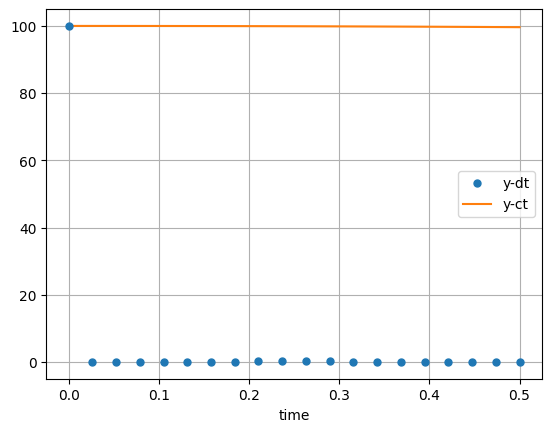

In [893]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()

_sol = history.subproblems[end].sol

tf = _sol.p[1]
xd = _sol.xd
ud = _sol.ud
vd = _sol.vd
p_sol = _sol.p
td = sol.td*tf

Nc = 100
tc = LinRange(0, tf, Nc)
xc = hcat([sample(sol.xc, t) for t in LinRange(0, 1, Nc)]...)

# ax.plot(td, xd[1, :], marker=".", linestyle="none", label="x")

# ax.plot(td, xd[2, :], marker=".", markersize=10, linestyle="none", label="y-dt", zorder=100)
# ax.plot(td, xd[2, :], linestyle="-", label="y-ct")

ax.plot(td, xd[2, :], marker=".", markersize=10, linestyle="none", label="y-dt", zorder=100)
ax.plot(tc, xc[2, :], linestyle="-", label="y-ct")

ax.legend()

ax.set_xlabel("time")
;

In [900]:
sample(sol.xc, 1)

7-element Vector{Float64}:
     1.0580921960645668e-13
    99.6249994059635
     4.684483763782397e-13
    -1.4999986643687697
     1.3520361544017553e-13
     5.878919388244513e-13
 25000.0

In [895]:
display(xc[2, end]-xc[2, 1])
display(xc[2, 1])
display(xc[2, end])

-0.3749993321840748

99.99999873814757

99.6249994059635

In [896]:
tf

0.4999999643381946

In [897]:
-0.5*g*(tf)^2

-0.37499994650729385

In [901]:
display(xc[4, 1])
display(xc[4, end])

1.2286471644529229e-6

-1.4999986643687697

In [899]:
-g*tf

-1.499999893014584

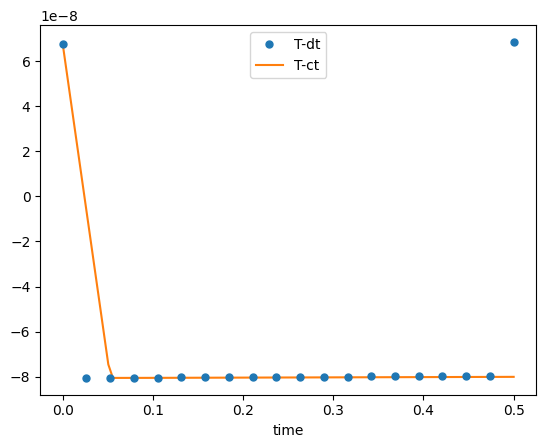

PyObject Text(0.5, 24.0, 'time')

In [874]:
fig = plt.figure()
ax = fig.add_subplot(111)

uc = hcat([sample(sol.uc, t) for t in tc]...)

ax.plot(td, ud[1, :], marker=".", markersize=10, linestyle="none", label="T-dt", zorder=100)
ax.plot(tc, uc[1, :], linestyle="-", label="T-ct")

ax.legend()

ax.set_xlabel("time")

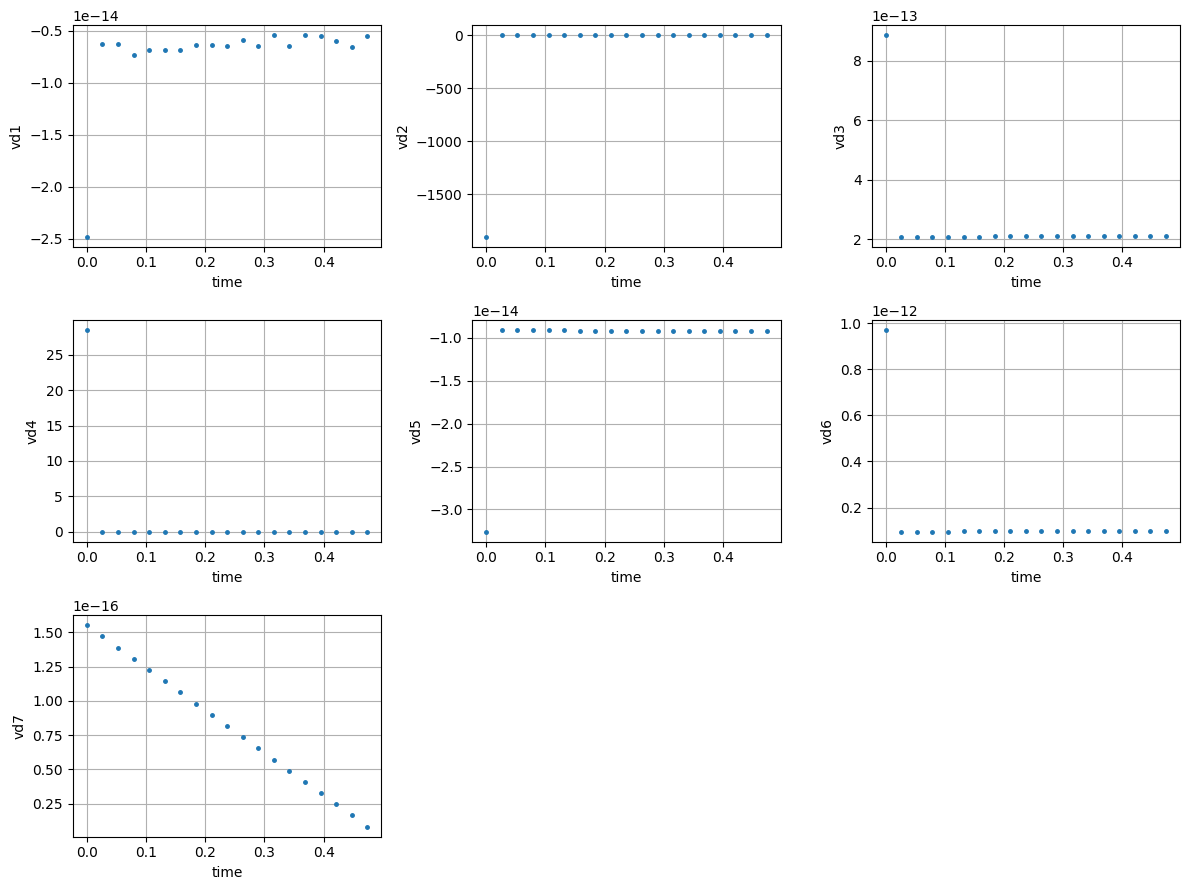

In [875]:
fig = plt.figure(figsize=(12, 9))
for i = 1:7
    ax = fig.add_subplot(3, 3, i)
    ax.grid()
    ax.plot(td[1:end-1], vd[i, :], marker=".", markersize=5, linestyle="none", label="T-dt", zorder=100)
    ax.set_ylabel("vd$i")
    ax.set_xlabel("time")
end
plt.tight_layout()

In [888]:
[(spbm.ref.p, spbm.sol.p) for spbm in history.subproblems]

30-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([10.0], [0.5000000005594798])
 ([0.5000000005594798], [10.56272924038074])
 ([10.56272924038074], [1.7543498562302489])
 ([1.7543498562302489], [0.49999994290619776])
 ([0.49999994290619776], [0.4999999912803216])
 ([0.4999999912803216], [0.4999999622775837])
 ([0.4999999622775837], [0.4999999622805248])
 ([0.4999999622805248], [0.49999996228629073])
 ([0.49999996228629073], [0.49999996229394394])
 ([0.49999996229394394], [0.499999962303888])
 ([0.499999962303888], [0.4999999623164669])
 ([0.4999999623164669], [0.4999999623321821])
 ([0.4999999623321821], [0.49999996235158245])
 ⋮
 ([0.49999996245961514], [0.49999996248373757])
 ([0.49999996248373757], [0.4999999625120908])
 ([0.4999999625120908], [0.4999999625452564])
 ([0.4999999625452564], [0.4999999625839323])
 ([0.4999999625839323], [0.4999999626287837])
 ([0.4999999626287837], [0.49999996272706676])
 ([0.49999996272706676], [0.4999999632086816])
 ([0.4999999632086816],

In [876]:
sol.xc

ContinuousTimeTrajectory([0.0, 0.0013175230566534915, 0.002635046113306983, 0.003952569169960474, 0.005270092226613966, 0.006587615283267457, 0.007905138339920948, 0.00922266139657444, 0.010540184453227932, 0.011857707509881422  …  0.9881422924901185, 0.9894598155467721, 0.9907773386034255, 0.9920948616600791, 0.9934123847167325, 0.994729907773386, 0.9960474308300395, 0.997364953886693, 0.9986824769433466, 1.0], [-1.7763568394002505e-15 -1.802004489891571e-15 … 1.0550072202185253e-13 1.0580921960645668e-13; 99.99999873814757 99.99999808800692 … 99.62598689635561 99.6249994059635; … ; -4.651834473179406e-14 -4.615959790077789e-14 … 5.875275295114055e-13 5.878919388244513e-13; 25000.0 25000.0 … 25000.0 25000.0], :linear)

In [877]:

xd

7×20 Matrix{Float64}:
    -1.77636e-15     -5.32907e-15  …      1.77636e-15      1.77636e-15
   100.0             -1.25594e-6          0.023786         1.26053e-6
    -3.90799e-14     -2.13163e-14         6.03961e-14      3.73035e-14
     1.22865e-6       1.42102             0.0789424       -2.45737e-6
    -4.44089e-16     -3.10862e-15        -2.22045e-16      6.66134e-16
    -4.65183e-14     -2.25375e-14  …      6.73905e-14      4.59632e-14
 25000.0          25000.0             25000.0          25000.0

In [878]:
# function set_fonts()::Nothing
#     # Set the figure fonts.
#     fig_small_sz = 12
#     fig_med_sz = 15
#     fig_big_sz = 17
#     plt.rc("text", usetex=true)
#     plt.rc("font", size=fig_small_sz, family="serif")
#     plt.rc("axes", titlesize=fig_small_sz)
#     plt.rc("axes", labelsize=fig_med_sz)
#     plt.rc("xtick", labelsize=fig_small_sz)
#     plt.rc("ytick", labelsize=fig_small_sz)
#     plt.rc("legend", fontsize=fig_small_sz)
#     plt.rc("figure", titlesize=fig_big_sz)
#     plt.rc("figure", dpi=300) 
#     return nothing
# end
# ;

In [879]:
# # Trajectory plot
# ctres, overlap = 1000, 3
# N = size(sol.xd, 2)
# xct = hcat([sample(sol.xc, t) for t in LinRange(0, 1, ctres)]...)
# vct = vcat([sample(sol.uc, t)[1] for t in LinRange(0, 1, ctres)]...)
# cmap = generate_colormap("inferno"; minval=minimum(vct), maxval=maximum(vct))

# # plot_options = Dict("xtick.labelsize"=>9,
# #                     "ytick.labelsize"=>9,
# #                     "axes.labelsize"=>11)
# # fig = create_figure((4, 4); options = plot_options)

# fig = plt.figure(figsize=(4,4), dpi=300)
# plt.clf()
# set_fonts()
# set_fonts()

# ax = setup_axis!(111, xlabel="\$x\$ [m]", ylabel="\$y\$ [m]",
#                  axis="equal", cbar=cmap, clabel="Velocity, \$v\$ [m/s]",
#                  cbar_aspect=40)
# ax.plot(sol.xd[1, :], sol.xd[2, :],
#         linestyle="none", marker="o", markerfacecolor=DarkBlue,
#         markeredgecolor="white", markeredgewidth=0.2, markersize=3,
#         zorder=20)
# line_segs = Vector{Matrix}(undef, 0)
# line_clrs = Vector{NTuple{4, Real}}(undef, 0)
# for k=1:ctres-overlap
#     push!(line_segs, xct[1:2, k:k+overlap]')
#     push!(line_clrs, cmap.to_rgba(vct[k]))
# end
# trajectory = PyPlot.matplotlib.collections.LineCollection(
#     line_segs, zorder=10, colors = line_clrs, linewidths=3,
#     capstyle="round")
# ax.add_collection(trajectory)
# Rect = PyPlot.matplotlib.patches.Rectangle
# car_length = 0.2
# for k=1:N
#     local xl, xw = [1;1;-1;-1;1]*car_length/2, [1;-1;-1;1;1]*car_width/2
#     local yl, yw = [1;1;-1;-1;1]*car_length/2, [-1;1;1;-1;-1]*car_width/2
#     local ang = sol.xd[3,k]
#     local xc = sol.xd[1,k].+xl.*sin(ang).+xw.*cos(ang)
#     local yc = sol.xd[2,k].+yl.*cos(ang).+yw.*sin(ang)
#     ax.fill(xc, yc,
#             linewidth=1,
#             edgecolor=DarkBlue,
#             facecolor=rgb2pyplot(parse(RGB, Red), a=0.5),
#             zorder=6)
# end
# ang = LinRange(0, 2*pi, 100)
# obs = ([cos.(ang)'; sin.(ang)']*r_0).+c_0
# ax.fill(obs[1, :], obs[2, :],
#         linewidth=1,
#         edgecolor=Blue,
#         facecolor=rgb2pyplot(parse(RGB, Green), a=0.5),
#         zorder=5)

# fig.savefig("../media/outputs/dubin_trajectory.png", dpi="figure", bbox_inches=nothing)

# plt.close()

## Replace figure

<!-- <div style="text-align: center">
    <img src="../media/outputs/dubin_trajectory.png"
         alt="Dubin's car overview"
         style="background-color: white; width: 500px; display: block; margin-left: auto; margin-right: auto;"/>
    <br />
    <b>Figure.</b> Computed Dubin's car trajectory for minimum-input usage.
</div> -->